In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

# for number crunching
import numpy as np
import scipy.stats as stats

import pandas as pd
# for data vicualizations
import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

In [2]:
# import the data
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
data = pd.read_csv(url,sep=';')
data = data[data['total sulfur dioxide']<200] # drop a few outliers

# z-score all columns except for quality
cols2zscore = data.keys()
cols2zscore = cols2zscore.drop('quality')
data[cols2zscore] = data[cols2zscore].apply(stats.zscore)

# create a new column for binarized (boolean) quality
data['boolQuality'] = 0
# data['boolQuality'][data['quality']<6] = 0 # implicit in the code! just here for clarity
data['boolQuality'][data['quality']>5] = 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [3]:
# convert from pandas dataframe to tensor
dataT = torch.tensor(data[cols2zscore].values).float()
labels = torch.tensor(data['boolQuality'].values).float()
labels = labels[:,None] # transform matrix

# use-scikitlearn to split the data
train_data,test_data,train_labels,test_labels = train_test_split(dataT,labels,test_size=.1)

# then convert them into pytorch datasets
train_dataDataset = torch.utils.data.TensorDataset(train_data,train_labels)
test_dataDataset = torch.utils.data.TensorDataset(test_data,test_labels)

# finally create dataloaders
train_loader = DataLoader(train_dataDataset,batch_size=32,shuffle=True,drop_last=True)
test_loader = DataLoader(test_dataDataset,batch_size=test_dataDataset.tensors[0].shape[0])

In [4]:
# create a class for the model

class ANNwine(nn.Module):
  def __init__(self):
    super().__init__()

    ### input layer
    self.input = nn.Linear(11,16)
    
    ### hidden layers
    self.fc1 = nn.Linear(16,32)
    self.fc2 = nn.Linear(32,32)

    ### output layer
    self.output = nn.Linear(32,1)
  
  # forward pass
  def forward(self,x):
    x = F.relu( self.input(x) )
    x = F.relu( self.fc1(x) )
    x = F.relu( self.fc2(x) )
    return self.output(x)

In [6]:
# function to train the model
numepochs = 1000

def trainTheModel():
    #loss function and optimizer
    lossfun = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.SGD(winenet.parameters(),lr=.01)

    #initialize losses
    losses = torch.zeros(numepochs)
    trainAcc = []
    testAcc = []

    for epochi in range(numepochs):


        #loop over epochs
        batchAcc = []
        batchLoss = []
        for X,y in train_loader:
            # forward pass and loss
            yHat = winenet(X)
            loss = lossfun(yHat,y)

            #backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            #loss from this batch
            batchLoss.append(loss.item())

        # compute training accuracy for this batch
            batchAcc.append(100*torch.mean(((yHat>0)==y).float()).item())

        trainAcc.append(np.mean(batchAcc))
    # and geta average losses across the batches
        losses[epochi] = np.mean(batchLoss)

    # test accuracy
        X,y = next(iter(test_loader))
        with torch.no_grad():
            yHat = winenet(X)

        testAcc.append(100*torch.mean(((yHat>0)==y).float()).item())

    return trainAcc,testAcc,losses



In [7]:
# now to create the fitted model
winenet = ANNwine()
trainAcc,testAcc,losses = trainTheModel()

# Compute the performance measure on the train and test data

In [8]:
# predictions for training data
train_predictions = winenet(train_loader.dataset.tensors[0])
train_predictions

# predictions for test_data
test_predictions = winenet(test_loader.dataset.tensors[0])
test_predictions


tensor([[ 4.5446e+00],
        [-1.6663e+00],
        [ 4.3353e+00],
        [-1.7682e+00],
        [ 9.0416e-01],
        [ 4.1863e-02],
        [ 2.7516e+00],
        [ 2.9203e+00],
        [ 2.7082e+00],
        [ 3.5485e+00],
        [ 1.6885e+00],
        [ 5.5223e+00],
        [-2.0653e+00],
        [-5.8327e+00],
        [-4.3633e+00],
        [ 5.5918e+00],
        [-5.8339e+00],
        [ 2.2603e-01],
        [-4.0787e+00],
        [ 8.9492e+00],
        [-1.2229e+00],
        [ 1.2850e+00],
        [ 1.0811e+00],
        [ 6.5510e+00],
        [-1.5816e+00],
        [-6.5768e+00],
        [-8.9341e-02],
        [-1.6727e+00],
        [-2.4405e+00],
        [ 2.9627e+00],
        [-4.9051e+00],
        [-1.6478e+00],
        [ 1.5773e+01],
        [-2.5547e+00],
        [-2.4953e+00],
        [-2.4083e+00],
        [ 9.1545e+00],
        [-5.9136e+00],
        [ 4.2311e-01],
        [ 1.6359e+00],
        [-1.9524e+00],
        [ 9.3249e-01],
        [ 9.4022e-01],
        [ 4

In [12]:
# NEW! using scikitlearn to compute ARPF
import sklearn.metrics as skm

# initialize vectors
train_metrics = [0,0,0,0]
test_metrics  = [0,0,0,0]

# training
train_metrics[0] = skm.accuracy_score (train_loader.dataset.tensors[1],train_predictions>0)
train_metrics[1] = skm.precision_score(train_loader.dataset.tensors[1],train_predictions>0)
train_metrics[2] = skm.recall_score   (train_loader.dataset.tensors[1],train_predictions>0)
train_metrics[3] = skm.f1_score       (train_loader.dataset.tensors[1],train_predictions>0)


# test
test_metrics[0] = skm.accuracy_score (test_loader.dataset.tensors[1],test_predictions>0)
test_metrics[1] = skm.precision_score(test_loader.dataset.tensors[1],test_predictions>0)
test_metrics[2] = skm.recall_score   (test_loader.dataset.tensors[1],test_predictions>0)
test_metrics[3] = skm.f1_score       (test_loader.dataset.tensors[1],test_predictions>0)

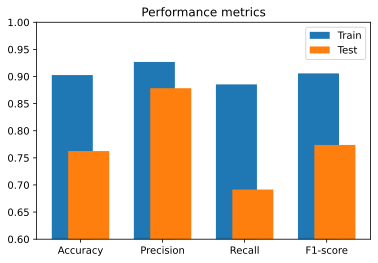

In [13]:
plt.bar(np.arange(4)-.1,train_metrics,.5)
plt.bar(np.arange(4)+.1,test_metrics,.5)
plt.xticks([0,1,2,3],['Accuracy','Precision','Recall','F1-score'])
plt.ylim([.6,1])
plt.legend(['Train','Test'])
plt.title('Performance metrics')
plt.show()

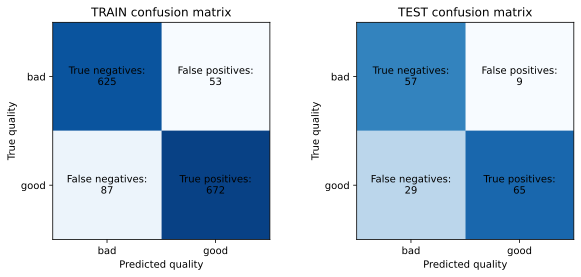

array([[625,  53],
       [ 87, 672]])

In [14]:
# Confusion matrices
trainConf = skm.confusion_matrix(train_loader.dataset.tensors[1],train_predictions>0)
testConf  = skm.confusion_matrix(test_loader.dataset.tensors[1], test_predictions>0)

fig,ax = plt.subplots(1,2,figsize=(10,4))

# confmat during TRAIN
ax[0].imshow(trainConf,'Blues',vmax=len(train_predictions)/2)
ax[0].set_xticks([0,1])
ax[0].set_yticks([0,1])
ax[0].set_xticklabels(['bad','good'])
ax[0].set_yticklabels(['bad','good'])
ax[0].set_xlabel('Predicted quality')
ax[0].set_ylabel('True quality')
ax[0].set_title('TRAIN confusion matrix')

# add text labels
ax[0].text(0,0,f'True negatives:\n{trainConf[0,0]}' ,ha='center',va='center')
ax[0].text(0,1,f'False negatives:\n{trainConf[1,0]}',ha='center',va='center')
ax[0].text(1,1,f'True positives:\n{trainConf[1,1]}' ,ha='center',va='center')
ax[0].text(1,0,f'False positives:\n{trainConf[0,1]}',ha='center',va='center')




# confmat during TEST
ax[1].imshow(testConf,'Blues',vmax=len(test_predictions)/2)
ax[1].set_xticks([0,1])
ax[1].set_yticks([0,1])
ax[1].set_xticklabels(['bad','good'])
ax[1].set_yticklabels(['bad','good'])
ax[1].set_xlabel('Predicted quality')
ax[1].set_ylabel('True quality')
ax[1].set_title('TEST confusion matrix')

# add text labels
ax[1].text(0,0,f'True negatives:\n{testConf[0,0]}' ,ha='center',va='center')
ax[1].text(0,1,f'False negatives:\n{testConf[1,0]}',ha='center',va='center')
ax[1].text(1,1,f'True positives:\n{testConf[1,1]}' ,ha='center',va='center')
ax[1].text(1,0,f'False positives:\n{testConf[0,1]}',ha='center',va='center')
plt.show()

trainConf